## SVM

### For all companies measure NMAPE for different lags using different columns

In [56]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tools import create_vectors, create_x_y

In [19]:
VITAL_COLS = ["date_", "ticker", "close", "diffs", "bin_2", "bin_3", "bin_5"]
LAGS = [3, 6, 8, 10, 16]
COMPANIES = ["amzn", "aapl", "tsla", "msft", "goog", "googl"]

In [76]:
def create_and_predict(x, y):
    tscv = TimeSeriesSplit(n_splits=4)
    cls = make_pipeline(MinMaxScaler(), SVC(C=1.0, kernel="linear", cache_size=1000))
    vals = cross_val_score(cls, x, y, scoring="accuracy", cv=tscv)
    return round(sum(vals) / len(vals), 4)


def measure(df, bin, lags):
    main_col = f"bin_{bin}"
    cols = [i for i in df.columns if i not in VITAL_COLS]
    results = {}

    for lag in lags:
        i = 0
        results[lag] = {}
        results[lag]["baseline"] = create_and_predict(
            *create_vectors(df, main_col=main_col, lag=lag + 1)
        )
        for col in cols:
            print(f"Lag {lag}: {i}/{len(cols)}")
            accuracy = create_and_predict(
                *create_vectors(df, main_col=main_col, cols=[col], lag=lag + 1)
            )
            results[lag][col] = (
                accuracy,
                "+" if accuracy > results[lag]["baseline"] else "-",
            )
            i += 1
    return results


def print_results(results):
    for i in results:
        print(i, results[i])


def find_best_hyper(df):
    cls = make_pipeline(MinMaxScaler(), SVC(cache_size=2000))
    params = {
        "svc__C": [0.1, 1, 10, 100, 1000],
        "svc__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
        "svc__kernel": ["linear", "rbf"],
    }
    x, y = create_x_y(df, x_cols=["diffs"], y_col="bin_3")

    grid = GridSearchCV(
        cls,
        param_grid=params,
        n_jobs=-1,
        cv=TimeSeriesSplit(n_splits=5),
    )
    grid.fit(x, y)

    return grid


def measure_conf_matrix(x, y):
    split = len(x) // 5
    cls = make_pipeline(MinMaxScaler(), SVC(C=1000, kernel="rbf", gamma=1, cache_size=1000))
    cls.fit(x[:-split], y[:-split])
    y_pred = cls.predict(x[-split:])
    print(pd.Series(y_pred).value_counts())

    return confusion_matrix(y[-split:], y_pred)

In [65]:
df = pd.read_csv("../datasets/relevant/amzn.csv", parse_dates=["date_"])

In [67]:
grid = find_best_hyper(df)

In [74]:
grid.best_params_

{'svc__C': 1000, 'svc__gamma': 1, 'svc__kernel': 'rbf'}

 0    1710
 1       7
-1       4
dtype: int64


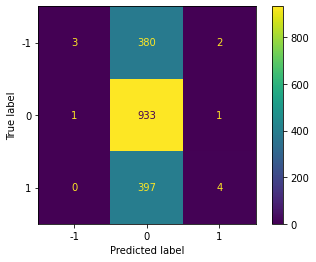

In [77]:
col = "bin_3"
cm = measure_conf_matrix(*create_x_y(df, x_cols=['diffs'], y_col=col))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df[col].unique()))
disp.plot()

plt.show()

In [49]:
x, y = create_x_y(df, x_cols=['diffs'], y_col='bin_3')

print(*x[:4], sep='\n')
print(y[:3])

[-1.454452666496553, 0.2556965302952019, -0.4358353510896084, -0.0162127107652287, -0.1070212420950289]
[0.2556965302952019, -0.4358353510896084, -0.0162127107652287, -0.1070212420950289, 0.1623271216154798]
[-0.4358353510896084, -0.0162127107652287, -0.1070212420950289, 0.1623271216154798, -1.520160767535328]
[-0.0162127107652287, -0.1070212420950289, 0.1623271216154798, -1.520160767535328, -0.177730967975509]
[0, -1, 0]


In [53]:
df['diffs'].head(10)

0   -1.454453
1    0.255697
2   -0.435835
3   -0.016213
4   -0.107021
5    0.162327
6   -1.520161
7   -0.177731
8   -0.075835
9   -0.478453
Name: diffs, dtype: float64

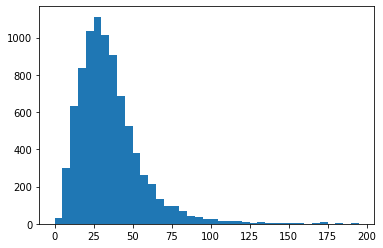

In [131]:
from matplotlib import pyplot as plt

plt.hist(df["count"], bins=[i for i in range(0, 200, 5)])
plt.show()

In [112]:
res = measure(df, 2, [3, 16])
print_results(res)

Lag 3: 0/10
Lag 3: 1/10
Lag 3: 2/10
Lag 3: 3/10
Lag 3: 4/10
Lag 3: 5/10
Lag 3: 6/10
Lag 3: 7/10
Lag 3: 8/10
Lag 3: 9/10
Lag 16: 0/10
Lag 16: 1/10
Lag 16: 2/10
Lag 16: 3/10
Lag 16: 4/10
Lag 16: 5/10
Lag 16: 6/10
Lag 16: 7/10
Lag 16: 8/10
Lag 16: 9/10
3 {'baseline': 0.5119, 'low': (0.5119, '-'), 'vol': (0.5119, '-'), 'max_pos': (0.5087, '-'), 'std_neg': (0.5119, '-'), 'std_pos': (0.5128, '+'), 'mean_comp': (0.525, '+'), 'mean_neg': (0.5392, '+'), 'mean_pos': (0.5173, '+'), 'median_comp': (0.5115, '-'), 'count': (0.5122, '+')}
16 {'baseline': 0.5105, 'low': (0.5068, '-'), 'vol': (0.5109, '+'), 'max_pos': (0.5122, '+'), 'std_neg': (0.5128, '+'), 'std_pos': (0.5108, '+'), 'mean_comp': (0.5236, '+'), 'mean_neg': (0.5278, '+'), 'mean_pos': (0.5189, '+'), 'median_comp': (0.5028, '-'), 'count': (0.5121, '+')}


In [118]:
results = {}
for company in COMPANIES:
    df = pd.read_csv(f"../datasets/relevant/{company}.csv", parse_dates=["date_"])
    results[company] = {}
    results[company][2] = create_and_predict(*create_vectors(df, main_col="bin_2"))
    results[company][3] = create_and_predict(*create_vectors(df, main_col="bin_3"))
    results[company][5] = create_and_predict(*create_vectors(df, main_col="bin_5"))

In [33]:
x, y = create_x_y(df, x_cols=['close'], y_col='bin_2')
x[:3], y[:3]

([[15.448, 15.4875, 15.419999999999998, 15.4175, 15.401],
  [15.4875, 15.419999999999998, 15.4175, 15.401, 15.425999999999998],
  [15.419999999999998, 15.4175, 15.401, 15.425999999999998, 15.1915]],
 [1, -1, -1])